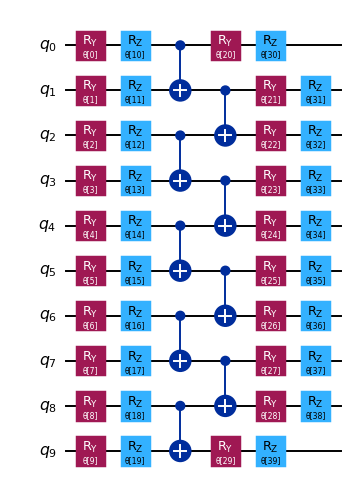

In [11]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 10
reps =  1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)
circuit.decompose().draw("mpl", scale=0.7)

In [12]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)

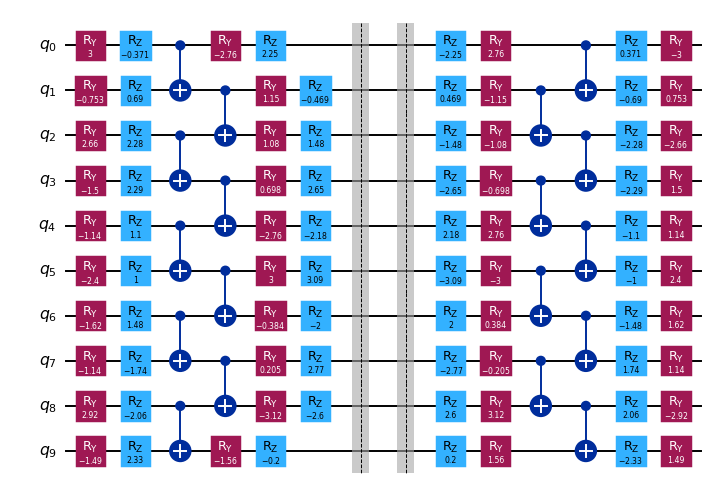

In [13]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

assigned_circuit = circuit.assign_parameters(params)
assigned_circuit.barrier()

mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)
mirror_circuit.decompose().draw("mpl", scale=0.7)

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

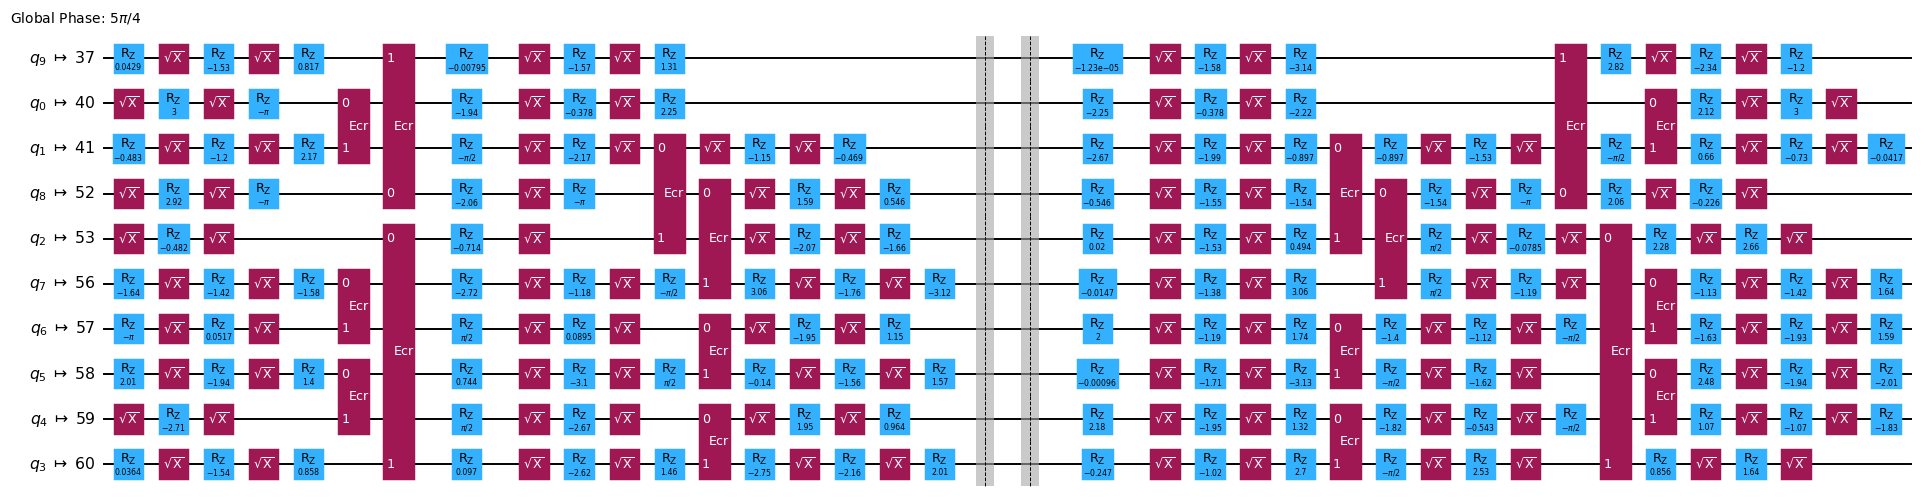

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)


In [16]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original Observable:")
print(observable)
print()
print("Observable with Layout Applied:")
print(isa_observable)

Original Observable:
SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])

Observable with Layout Applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


In [17]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    #num of shots
    estimator.options_default_shots = 100_000
    #disable runtime complilation and err mitigation
    estimator.options.optimization_level = 0
    estimator.options.resilience_level = 0

    #Run job w/ no err mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    #Dynamical Decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    #Add readout err mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    #W/ Gate Twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    #w/ Zero Noise Extrapolations (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

qiskit_runtime_service.check_pending_jobs:WARNING:2024-10-23 12:19:32,991: The pending jobs limit has been reached. Waiting for job <RuntimeJob('ctgvvmpzhysg008ryv4g', 'estimator')> to finish before submitting the next one.
qiskit_runtime_service.check_pending_jobs:WARNING:2024-10-23 12:20:23,594: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cwc4fyzjyrs0008x1xrg', 'estimator')> to finish before submitting the next one.
qiskit_runtime_service.check_pending_jobs:WARNING:2024-10-23 12:21:05,360: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cwc4sgyjyrs0008x1yhg', 'estimator')> to finish before submitting the next one.


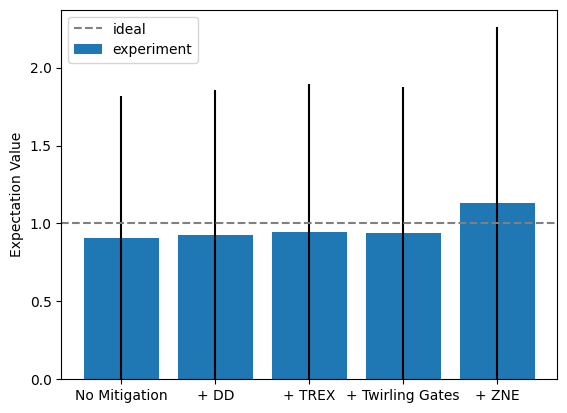

In [21]:
import matplotlib.pyplot as plt

#Job result retrieval 
results = [job.result() for job in jobs]

#Unpack PUB results
pub_results = [result[0] for result in results]

#Unpack expectation values and std error
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.evs) for pub_result in pub_results])

#Plot expectation values
fig, ax = plt.subplots()
labels = ["No Mitigation", "+ DD", "+ TREX", "+ Twirling Gates", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr= standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation Value")
ax.legend(loc="upper left")

plt.show()

qiskit_runtime_service.check_pending_jobs:WARNING:2024-10-23 12:40:39,436: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cwc7wf99ezk00089428g', 'estimator')> to finish before submitting the next one.
qiskit_runtime_service.check_pending_jobs:WARNING:2024-10-23 12:41:10,368: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cwc7wga2802g00861qag', 'estimator')> to finish before submitting the next one.


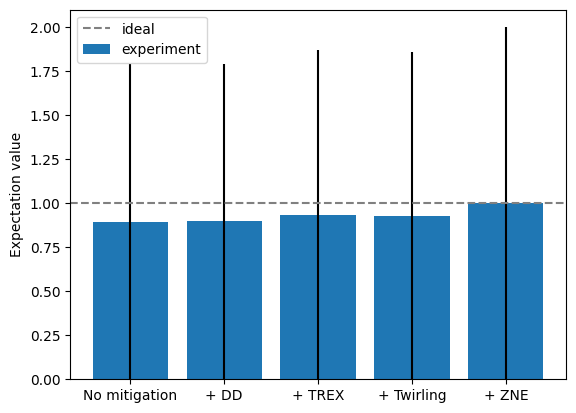

In [23]:
n_qubits = 50
reps = 1

# Construct circuit and observable
circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)
observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=n_qubits)

# Assign parameters to circuit
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)
assigned_circuit = circuit.assign_parameters(params)
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

# Transpile circuit and observable
isa_circuit = pass_manager.run(mirror_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

# Run jobs
pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    #num of shots
    estimator.options_default_shots = 100_000
    #disable runtime complilation and err mitigation
    estimator.options.optimization_level = 0
    estimator.options.resilience_level = 0

    #Run job w/ no err mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    #Dynamical Decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    #Add readout err mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    #W/ Gate Twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    #w/ Zero Noise Extrapolations (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)


#Job result retrieval 
results = [job.result() for job in jobs]

#Unpack PUB results
pub_results = [result[0] for result in results]

#Unpack expectation values and std error
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.evs) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()